In [1]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'

train_cleaned = pd.read_pickle(PATH + 'train_merged.pkl')
test_cleaned = pd.read_pickle(PATH + 'test_merged.pkl')
print('done')

done


In [1]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'

train_cleaned = pd.read_csv(PATH + 'train_test.csv')
test_cleaned = pd.read_csv(PATH + 'test_test.csv')
'done'

'done'

In [2]:
from sklearn.preprocessing import LabelEncoder

categorical_feats = [
    'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

for x in categorical_feats:
    if train_cleaned[x].dtype == 'object':
        print(x)
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)
        train_cleaned[x] = LabelEncoder().fit_transform(train_cleaned[x])
        test_cleaned[x] = LabelEncoder().fit_transform(test_cleaned[x])
    else:
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)
print('done')

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
done


In [3]:
target = train_cleaned['TARGET']
ignore_cols = ['ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR', 'FLAG_MOBIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'CREDIT_ACTIVE_Bad_debt', 'CREDIT_TYPE_Cash_loan_(non-earmarked)', 'CREDIT_TYPE_Interbank_credit', 'CREDIT_TYPE_Loan_for_purchase_of_shares_(margin_lending)', 'CREDIT_TYPE_Loan_for_the_purchase_of_equipment', 'CREDIT_TYPE_Mobile_operator_loan', 'CREDIT_TYPE_Real_estate_loan', 'bureau_bureau_balance_score_min', 'bureau_AMT_CREDIT_SUM_DEBT_divide_AMT_CREDIT_SUM_OVERDUE_std', 'bureau_CREDIT_DAY_OVERDUE_min', 'bureau_AMT_CREDIT_SUM_OVERDUE_min', 'bureau_CNT_CREDIT_PROLONG_min', 'installments_late_days_max', 'NAME_CASH_LOAN_PURPOSE_Business_development', 'NAME_CASH_LOAN_PURPOSE_Buying_a_garage', 'NAME_CASH_LOAN_PURPOSE_Furniture', 'NAME_CASH_LOAN_PURPOSE_Hobby', 'NAME_CASH_LOAN_PURPOSE_Money_for_a_third_person', 'NAME_CASH_LOAN_PURPOSE_Purchase_of_electronic_equipment', 'NAME_CASH_LOAN_PURPOSE_Refusal_to_name_the_goal', 'NAME_PAYMENT_TYPE_Cashless_from_the_account_of_the_employer', 'CODE_REJECT_REASON_SYSTEM', 'NAME_GOODS_CATEGORY_Additional_Service', 'NAME_GOODS_CATEGORY_Animals', 'NAME_GOODS_CATEGORY_Education', 'NAME_GOODS_CATEGORY_Fitness', 'NAME_GOODS_CATEGORY_House_Construction', 'NAME_GOODS_CATEGORY_Office_Appliances', 'NAME_GOODS_CATEGORY_Tourism', 'NAME_PORTFOLIO_Cars', 'CHANNEL_TYPE_Car_dealer', 'NAME_SELLER_INDUSTRY_Tourism', 'credit_card_SK_DPD_min', 'credit_card_SK_DPD_DEF_min', 'credit_card_AMT_DRAWINGS_OTHER_CURRENT_min', 'credit_card_CNT_DRAWINGS_OTHER_CURRENT_min', 'credit_card_AMT_DRAWINGS_OTHER_CURRENT_divide_AMT_DRAWINGS_CURRENT_min', 'credit_card_CNT_DRAWINGS_OTHER_CURRENT_divide_CNT_DRAWINGS_CURRENT_min', 'POS_CASH_balance_SK_DPD_DEF_min', 'NAME_CONTRACT_STATUS_Amortized_debt', 'NAME_CONTRACT_STATUS_Canceled_y', 'NAME_CONTRACT_STATUS_XNA', 'bureau_STATUS_3_max', 'bureau_STATUS_4_max', 'bureau_STATUS_3_min', 'bureau_STATUS_4_min']
features = [x for x in train_cleaned.columns if x not in ignore_cols]
categorical_feats = [x for x in categorical_feats if x not in ignore_cols]
train = train_cleaned[features]
test = test_cleaned[features]

In [6]:
%%time

from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

lgbm_train = lgbm.Dataset(data=train,
                          label=target,
                          
                          categorical_feature=categorical_feats,
                          free_raw_data=False)

lgbm_params = {'num_threads': 16, 'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 10000, 'verbose': 100,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}

cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     early_stopping_rounds=150,
                     verbose_eval=200,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's auc: 0.743746 + 0.00265239
[400]	cv_agg's auc: 0.752754 + 0.00289628
[600]	cv_agg's auc: 0.760784 + 0.00261062
[800]	cv_agg's auc: 0.764656 + 0.00213366
[1000]	cv_agg's auc: 0.766365 + 0.00221189
[1200]	cv_agg's auc: 0.767167 + 0.00203962
[1400]	cv_agg's auc: 0.767606 + 0.00191026
[1600]	cv_agg's auc: 0.767874 + 0.00187495
[1800]	cv_agg's auc: 0.768012 + 0.00177013
[2000]	cv_agg's auc: 0.768118 + 0.0017233
[2200]	cv_agg's auc: 0.768201 + 0.00175306
[2400]	cv_agg's auc: 0.768253 + 0.00179195
Optimum boost rounds = 2393
Best CV result = 0.7682665072732815
CPU times: user 2h 18min 44s, sys: 19.7 s, total: 2h 19min 4s
Wall time: 8min 44s


In [7]:
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=int(optimum_boost_rounds*1.1))

""" Predict on test set and create submission """
y_pred = clf.predict(test)
out_df = pd.DataFrame({'SK_ID_CURR': test_cleaned['SK_ID_CURR'], 'TARGET': y_pred})
print('done')

/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


done


In [8]:
print((out_df['TARGET']>0.5).sum())

129


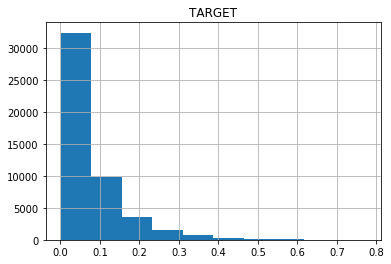

In [9]:
import matplotlib.pyplot as plt
out_df[['TARGET']].hist()
plt.show()

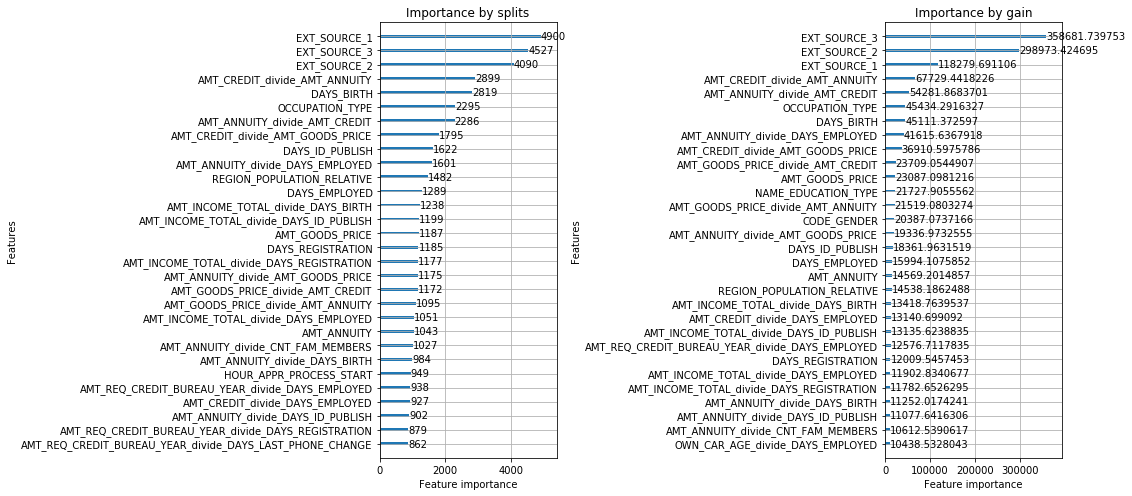

In [10]:
import matplotlib.pyplot as plt

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=30, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=30, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.show()

In [9]:
out_df.to_csv(PATH + 'submission_merged.csv', index=False)
print('done')

done


In [11]:
import json

y = [x for x in zip(clf.feature_name(), clf.feature_importance('gain'))]
y.sort(key=lambda x: x[1], reverse=True)
y = [(i, j) for i, j in enumerate(y)]
y
# with open('./importance_gain.json') as f:
#     json.dump(x, f)

[(0, ('EXT_SOURCE_3', 358681.73975273967)),
 (1, ('EXT_SOURCE_2', 298973.42469516397)),
 (2, ('EXT_SOURCE_1', 118279.69110582769)),
 (3, ('AMT_CREDIT_divide_AMT_ANNUITY', 67729.441822588444)),
 (4, ('AMT_ANNUITY_divide_AMT_CREDIT', 54281.868370056152)),
 (5, ('OCCUPATION_TYPE', 45434.291632652283)),
 (6, ('DAYS_BIRTH', 45111.372596979141)),
 (7, ('AMT_ANNUITY_divide_DAYS_EMPLOYED', 41615.636791825294)),
 (8, ('AMT_CREDIT_divide_AMT_GOODS_PRICE', 36910.597578585148)),
 (9, ('AMT_GOODS_PRICE_divide_AMT_CREDIT', 23709.054490685463)),
 (10, ('AMT_GOODS_PRICE', 23087.098121583462)),
 (11, ('NAME_EDUCATION_TYPE', 21727.905556201935)),
 (12, ('AMT_GOODS_PRICE_divide_AMT_ANNUITY', 21519.080327391624)),
 (13, ('CODE_GENDER', 20387.073716640472)),
 (14, ('AMT_ANNUITY_divide_AMT_GOODS_PRICE', 19336.973255515099)),
 (15, ('DAYS_ID_PUBLISH', 18361.963151872158)),
 (16, ('DAYS_EMPLOYED', 15994.107585221529)),
 (17, ('AMT_ANNUITY', 14569.201485723257)),
 (18, ('REGION_POPULATION_RELATIVE', 14538.1862

In [12]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('split'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
x
# with open('./importance_split.json') as f:
#     json.dump(x, f)

[(0, ('EXT_SOURCE_1', 4900)),
 (1, ('EXT_SOURCE_3', 4527)),
 (2, ('EXT_SOURCE_2', 4090)),
 (3, ('AMT_CREDIT_divide_AMT_ANNUITY', 2899)),
 (4, ('DAYS_BIRTH', 2819)),
 (5, ('OCCUPATION_TYPE', 2295)),
 (6, ('AMT_ANNUITY_divide_AMT_CREDIT', 2286)),
 (7, ('AMT_CREDIT_divide_AMT_GOODS_PRICE', 1795)),
 (8, ('DAYS_ID_PUBLISH', 1622)),
 (9, ('AMT_ANNUITY_divide_DAYS_EMPLOYED', 1601)),
 (10, ('REGION_POPULATION_RELATIVE', 1482)),
 (11, ('DAYS_EMPLOYED', 1289)),
 (12, ('AMT_INCOME_TOTAL_divide_DAYS_BIRTH', 1238)),
 (13, ('AMT_INCOME_TOTAL_divide_DAYS_ID_PUBLISH', 1199)),
 (14, ('AMT_GOODS_PRICE', 1187)),
 (15, ('DAYS_REGISTRATION', 1185)),
 (16, ('AMT_INCOME_TOTAL_divide_DAYS_REGISTRATION', 1177)),
 (17, ('AMT_ANNUITY_divide_AMT_GOODS_PRICE', 1175)),
 (18, ('AMT_GOODS_PRICE_divide_AMT_CREDIT', 1172)),
 (19, ('AMT_GOODS_PRICE_divide_AMT_ANNUITY', 1095)),
 (20, ('AMT_INCOME_TOTAL_divide_DAYS_EMPLOYED', 1051)),
 (21, ('AMT_ANNUITY', 1043)),
 (22, ('AMT_ANNUITY_divide_CNT_FAM_MEMBERS', 1027)),
 (23, 